In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn import svm

filepath = '../input/titanic/train.csv'
testfilepath = '../input/titanic/test.csv'
trainset_full = pd.read_csv(filepath)
testset = pd.read_csv(testfilepath)

trainset = trainset_full.drop('Survived',axis = 1)
y = trainset_full['Survived']

fullset = pd.concat([trainset,testset]).reset_index(drop = True)

In [2]:
# Extract the information of the title from the name category 

Namelist = fullset['Name'].values.tolist()
fullset['Title'] = pd.Series([Namelist[i].split(', ')[1].split('.')[0] for i in range(len(Namelist))])
fullset['Title'] = fullset['Title'].replace(['Miss', 'Mlle'], 'Miss')
fullset['Title'] = fullset['Title'].replace(['Mrs','Ms', 'Mme'], 'Mrs')
fullset['Title'] = fullset['Title'].replace(['Dr', 'Col', 'Major','Capt', 'Rev'], 'Officer')
fullset['Title'] = fullset['Title'].replace(['Jonkheer', 'Sir', 'Don', 'Dona', 'Lady', 'the Countess'], 'Royalty')
fullset = fullset.drop('PassengerId',axis = 1)
fullset = fullset.drop('Name',axis = 1)

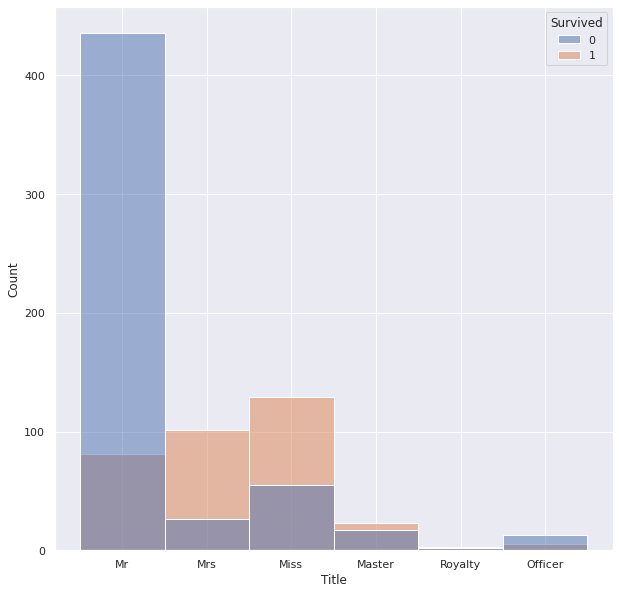

In [3]:
# Display the survive rate by title

sns.set(rc={"figure.figsize":(10, 10)})
trainset_temp = fullset.loc[:len(trainset)-1]
title_vs_surv = pd.concat([trainset_temp['Title'],y], axis = 1)
sns.histplot(data=title_vs_surv, x='Title', hue='Survived')
plt.show()

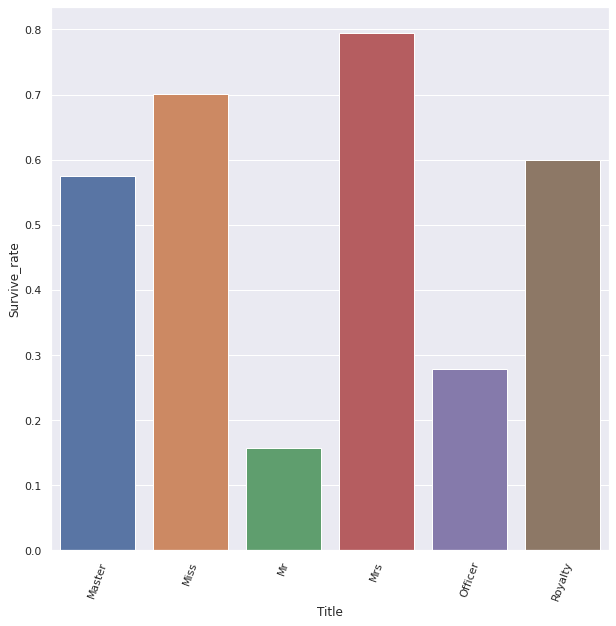

In [4]:
titlelist = title_vs_surv.groupby('Title').sum().index.tolist()
survived = [title_vs_surv.groupby('Title').sum().values.tolist()[i][0] for i in range(len(titlelist))]
numberbytitle = [title_vs_surv['Title'].values.tolist().count(titlelist[i]) for i in range(len(titlelist))]
surv_rate_title = [survived[i]/numberbytitle[i] for i in range(len(survived))]
data = {'Title' : titlelist, 'Survive_rate' : surv_rate_title}
title_vs_surrate = pd.DataFrame(data)
sns.barplot(x=title_vs_surrate.Title, y=title_vs_surrate.Survive_rate)
plt.xticks(rotation = 70)
plt.show()

[270, 914, 123]


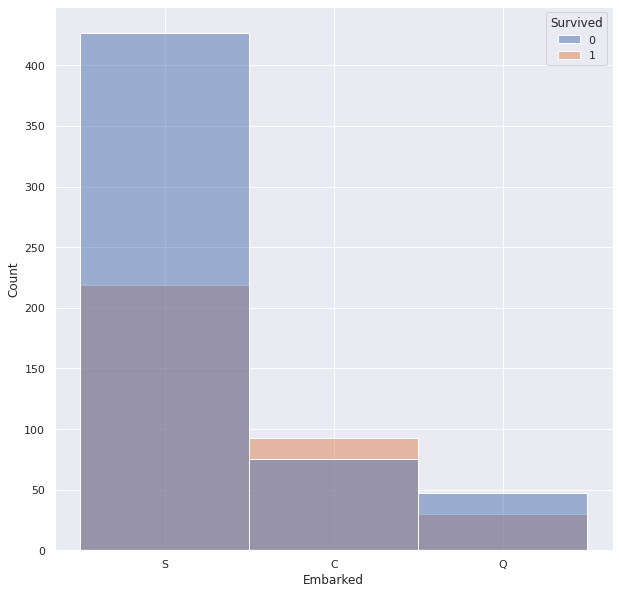

In [5]:
# The number of missing data in 'Embarked' is very small, so impute them by the most frequent data
print([fullset.Embarked.values.tolist().count('C'),fullset.Embarked.values.tolist().count('S'),fullset.Embarked.values.tolist().count('Q')])
fullset['Embarked'] = fullset['Embarked'].fillna('S')

sns.set(rc={"figure.figsize":(10, 10)})
title_vs_surv = pd.concat([trainset_temp['Embarked'],y], axis = 1)
sns.histplot(data=title_vs_surv, x='Embarked', hue='Survived')
plt.show()

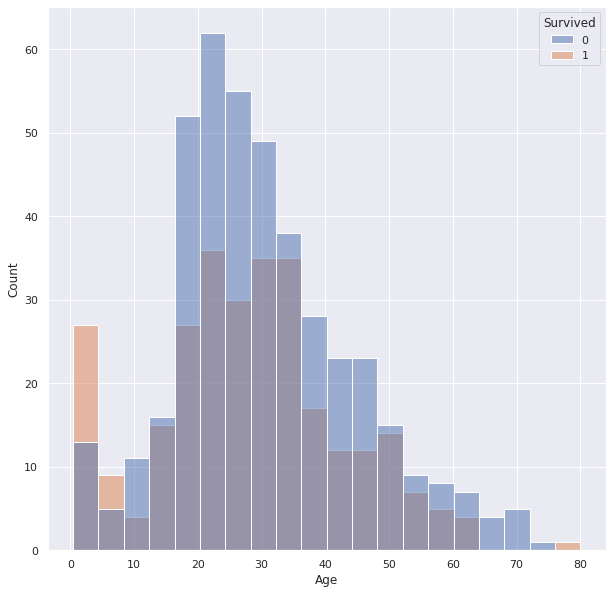

In [6]:
age_vs_surv = pd.concat([trainset_temp['Age'],y], axis = 1)
sns.histplot(data=age_vs_surv, x='Age', hue='Survived')
plt.show()

In [7]:
# impute age 
print(fullset.groupby(['Pclass','Sex'])['Age'].median())
fullset['Age'] = fullset.groupby(['Pclass','Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

Pclass  Sex   
1       female    36.0
        male      42.0
2       female    28.0
        male      29.5
3       female    22.0
        male      25.0
Name: Age, dtype: float64


In [8]:
# impute fare
Ticket_identical = []
for i in range(len(fullset)):
    Ticket_identical = Ticket_identical + [fullset['Ticket'].values.tolist().count(fullset['Ticket'][i])]
farelist=fullset['Fare'].values.tolist()
fullset['Fare'] = pd.Series([farelist[i]/Ticket_identical[i] for i in range(len(farelist))])
Pclass3mean = fullset.groupby(['Pclass','SibSp','Parch']).Fare.median()[3][0][0]
fullset['Fare'] = fullset['Fare'].fillna(Pclass3mean)

In [9]:
# Add the deck data from the cabin

fullset['Deck'] = fullset['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'U')
idx = fullset[fullset['Deck'] == 'T'].index
fullset.loc[idx, 'Deck'] = 'A'
fullset['Deck'] = fullset['Deck'].replace(['A', 'B', 'C'], 'ABC')
fullset['Deck'] = fullset['Deck'].replace(['D', 'E'], 'DE')
fullset['Deck'] = fullset['Deck'].replace(['F', 'G'], 'FG')
fullset = fullset.drop('Cabin',axis = 1)

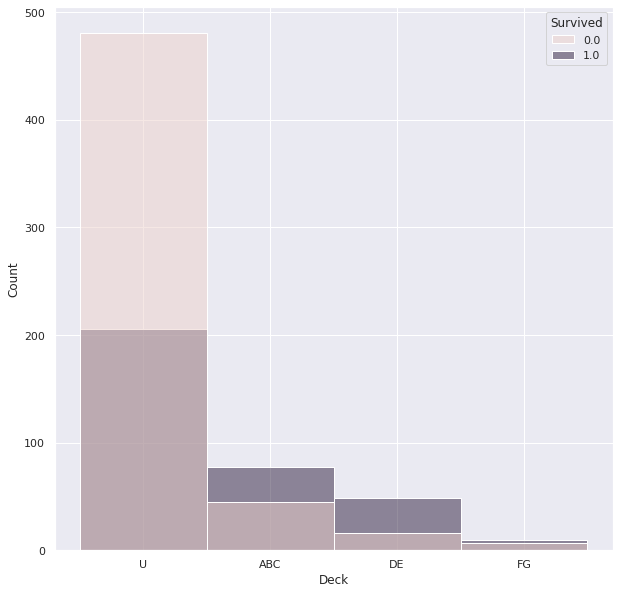

In [10]:
deck_vs_surv = pd.concat([fullset['Deck'],y], axis = 1)
sns.histplot(data=deck_vs_surv, x='Deck', hue='Survived')
plt.show()

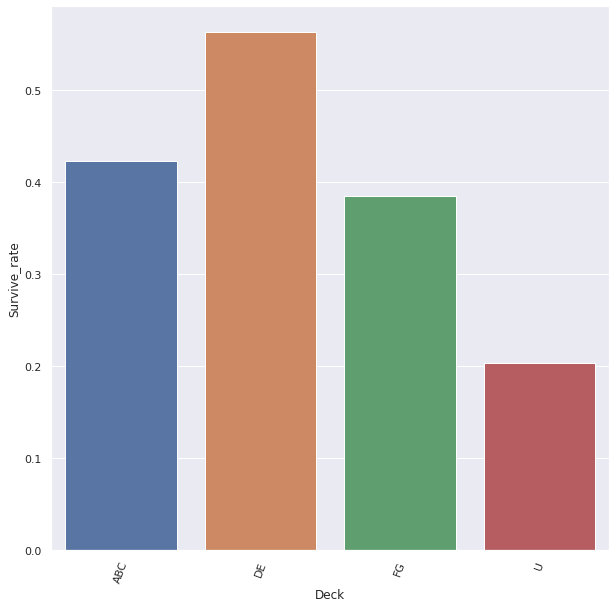

In [11]:
decklist = deck_vs_surv.groupby('Deck').sum().index.tolist()
survived = [deck_vs_surv.groupby('Deck').sum().values.tolist()[i][0] for i in range(len(decklist))]
numberbydeck = [deck_vs_surv['Deck'].values.tolist().count(decklist[i]) for i in range(len(decklist))]
surv_rate_deck = [survived[i]/numberbydeck[i] for i in range(len(survived))]
data = {'Deck' : decklist, 'Survive_rate' : surv_rate_deck}
deck_vs_surrate = pd.DataFrame(data)
sns.barplot(x=deck_vs_surrate.Deck, y=deck_vs_surrate.Survive_rate)
plt.xticks(rotation = 70)
plt.show()

In [12]:
# introduce the family size group from sibsp and parch

fullset['Family_Size'] = fullset['SibSp'] + fullset['Parch'] + 1
family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
fullset['Family_Size_Grouped'] = fullset['Family_Size'].map(family_map)

In [13]:
fullset = fullset.drop('Ticket',axis = 1)
fullset['Pclass'] = fullset['Pclass'].astype(str)

In [14]:
cat_cols = ['Embarked','Sex','Title','Deck','Family_Size_Grouped','Pclass']
num_cols = ['Fare','Age']
        
OH_encoder = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
OH_cols = pd.DataFrame(OH_encoder.fit_transform(fullset[cat_cols]))
OH_cols.index = fullset.index
OH_cols.columns = OH_encoder.get_feature_names(cat_cols)
fullset_A = fullset.drop(cat_cols,axis = 1)
fullset_A = pd.concat([fullset_A, OH_cols], axis = 1)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [15]:
trainset_inp = fullset_A.loc[:len(trainset)-1]
testset_inp = fullset_A.loc[len(trainset):]

y = trainset_full['Survived']

In [16]:
#fullset_A = fullset_A.drop('SibSp', axis = 1)
#fullset_A = fullset_A.drop('Parch', axis = 1)
#fullset_A = fullset_A.drop('Fare', axis = 1)
#fullset_A = fullset_A.drop('Age', axis = 1)
fullset_A = fullset_A.drop('Family_Size', axis = 1)
fullset_A.head()

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Title_Master,...,Deck_DE,Deck_FG,Deck_U,Family_Size_Grouped_Alone,Family_Size_Grouped_Large,Family_Size_Grouped_Medium,Family_Size_Grouped_Small,Pclass_1,Pclass_2,Pclass_3
0,22.0,1,0,7.25000,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,38.0,1,0,35.64165,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,26.0,0,0,7.92500,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,35.0,1,0,26.55000,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,35.0,0,0,8.05000,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [17]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.3)
yhat = iso.fit_predict(trainset_inp)

listyhat=yhat.tolist()
pos1=[i for i in range(len(listyhat)) if listyhat[i]==1]
trainset_inp = trainset_inp.loc[pos1].reset_index(drop=True)
y = y.loc[pos1].reset_index(drop=True)

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(trainset_inp, y, train_size = 0.7, test_size = 0.3, random_state = 3)

clf = RandomForestClassifier(n_estimators=1000, max_depth=2)
clf.fit(X_train, y_train)
clf.predict(X_valid)
print(clf.score(X_valid,y_valid))

0.7978723404255319


In [19]:
y_pred_test=clf.predict(testset_inp)
predictset = y_pred_test.tolist()

output = pd.DataFrame({'PassengerId': testset['PassengerId'].tolist(), 'Survived': y_pred_test.tolist()})
output.to_csv('submission.csv', index=False)

In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(trainset_inp, y, train_size = 0.7, test_size = 0.3, random_state = 2)

clf = GradientBoostingClassifier(learning_rate = 0.001, n_estimators=3000)
clf.fit(X_train, y_train)
clf.predict(X_valid)
clf.score(X_valid,y_valid)

0.8191489361702128

In [21]:
y_pred_test=clf.predict(testset_inp)
predictset = y_pred_test.tolist()

output = pd.DataFrame({'PassengerId': testset['PassengerId'].tolist(), 'Survived': y_pred_test.tolist()})
output.to_csv('submission.csv', index=False)